# Chapter 5: Autonomous Agents（自律エージェント）

このノートブックは [Nature of Code](https://natureofcode.com/autonomous-agents/) の第5章をJuliaで実装したものです。

## 概要

自律エージェントとは、環境を認識し、自らの判断で行動を決定するオブジェクトです。
この章では、Craig Reynoldsが開発した**ステアリング行動（Steering Behaviors）**を学びます。

### 核心となる公式

```
steering force = desired velocity − current velocity
（操舵力 = 目標速度 − 現在の速度）
```

この単純な式が、すべてのステアリング行動の基礎となります。

In [1]:
# 必要なパッケージ
using LinearAlgebra
using Plots
using Statistics

# ベクトル操作のヘルパー関数
normalize(v) = norm(v) > 0 ? v / norm(v) : v
setmag(v, m) = normalize(v) * m
limit(v, max) = norm(v) > max ? setmag(v, max) : v

limit (generic function with 1 method)

## 5.1 Vehicle（乗り物）クラス

自律エージェントの基本構造を定義します。

In [2]:
mutable struct Vehicle
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    maxspeed::Float64
    maxforce::Float64
    r::Float64  # 半径（描画用）
end

# コンストラクタ
function Vehicle(x::Float64, y::Float64)
    Vehicle(
        [x, y],           # position
        [0.0, 0.0],       # velocity
        [0.0, 0.0],       # acceleration
        4.0,              # maxspeed
        0.1,              # maxforce
        6.0               # r
    )
end

# 力を適用
function applyforce!(v::Vehicle, force::Vector{Float64})
    v.acceleration .+= force
end

# 更新
function update!(v::Vehicle)
    v.velocity .+= v.acceleration
    v.velocity = limit(v.velocity, v.maxspeed)
    v.position .+= v.velocity
    v.acceleration .= 0.0
end

update! (generic function with 1 method)

## 5.2 Seeking（追跡行動）

目標に向かって移動する最も基本的なステアリング行動です。

1. 目標への方向ベクトルを計算
2. 最大速度にスケール（desired velocity）
3. steering = desired - velocity

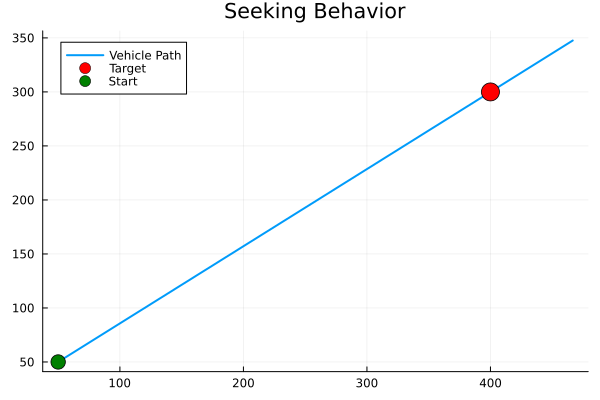

In [3]:
function seek!(v::Vehicle, target::Vector{Float64})
    # 目標方向への希望速度
    desired = target - v.position
    desired = setmag(desired, v.maxspeed)
    
    # ステアリング力 = 希望速度 - 現在速度
    steer = desired - v.velocity
    steer = limit(steer, v.maxforce)
    
    applyforce!(v, steer)
end

# シミュレーション
function simulate_seek()
    vehicle = Vehicle(50.0, 50.0)
    target = [400.0, 300.0]
    
    positions = Vector{Vector{Float64}}()
    
    for _ in 1:200
        seek!(vehicle, target)
        update!(vehicle)
        push!(positions, copy(vehicle.position))
    end
    
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    
    plot(xs, ys, label="Vehicle Path", linewidth=2)
    scatter!([target[1]], [target[2]], label="Target", markersize=10, color=:red)
    scatter!([50.0], [50.0], label="Start", markersize=8, color=:green)
    title!("Seeking Behavior")
end

simulate_seek()

## 5.3 Fleeing（逃避行動）

Seekingの逆で、目標から**離れる**方向に移動します。

In [4]:
function flee!(v::Vehicle, target::Vector{Float64})
    # 目標から離れる方向への希望速度
    desired = v.position - target  # Seekと逆
    desired = setmag(desired, v.maxspeed)
    
    steer = desired - v.velocity
    steer = limit(steer, v.maxforce)
    
    applyforce!(v, steer)
end

flee! (generic function with 1 method)

## 5.4 Arriving（到着行動）

Seekingの問題点は、目標を通り過ぎてしまうことです。
Arrivingでは、目標に近づくにつれて**減速**します。

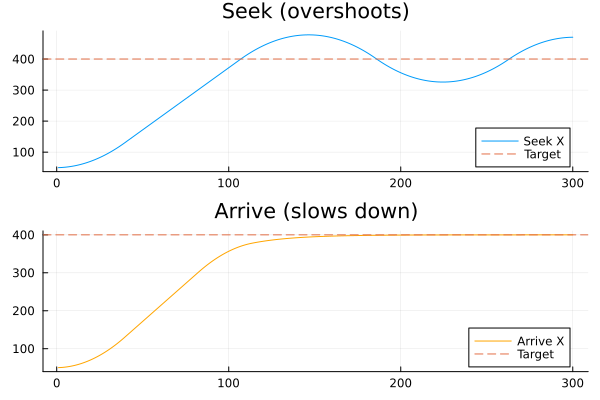

In [5]:
function arrive!(v::Vehicle, target::Vector{Float64}; slowingRadius::Float64=100.0)
    desired = target - v.position
    d = norm(desired)
    
    # 減速半径内なら速度を距離に比例させる
    if d < slowingRadius
        m = (d / slowingRadius) * v.maxspeed
        desired = setmag(desired, m)
    else
        desired = setmag(desired, v.maxspeed)
    end
    
    steer = desired - v.velocity
    steer = limit(steer, v.maxforce)
    
    applyforce!(v, steer)
end

# Seek vs Arrive の比較
function compare_seek_arrive()
    vehicle_seek = Vehicle(50.0, 200.0)
    vehicle_arrive = Vehicle(50.0, 200.0)
    target = [400.0, 200.0]
    
    seek_pos = Vector{Vector{Float64}}()
    arrive_pos = Vector{Vector{Float64}}()
    
    for _ in 1:300
        seek!(vehicle_seek, target)
        arrive!(vehicle_arrive, target)
        
        update!(vehicle_seek)
        update!(vehicle_arrive)
        
        push!(seek_pos, copy(vehicle_seek.position))
        push!(arrive_pos, copy(vehicle_arrive.position))
    end
    
    p1 = plot([p[1] for p in seek_pos], label="Seek X", title="Seek (overshoots)")
    hline!([target[1]], label="Target", linestyle=:dash)
    
    p2 = plot([p[1] for p in arrive_pos], label="Arrive X", title="Arrive (slows down)", color=:orange)
    hline!([target[1]], label="Target", linestyle=:dash)
    
    plot(p1, p2, layout=(2,1))
end

compare_seek_arrive()

## 5.5 Wandering（徘徊行動）

ランダムに見えるが滑らかな動きを作り出す行動です。
エージェントの前方に円を置き、その円周上のランダムな点を目標とします。

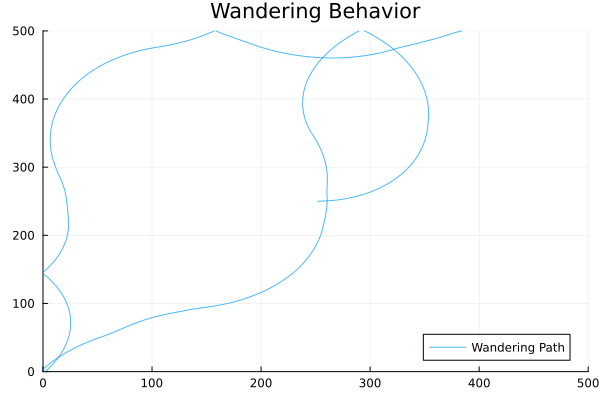

In [6]:
mutable struct WanderingVehicle
    vehicle::Vehicle
    wanderθ::Float64  # 徘徊角度
end

function WanderingVehicle(x::Float64, y::Float64)
    WanderingVehicle(Vehicle(x, y), 0.0)
end

function wander!(wv::WanderingVehicle)
    v = wv.vehicle
    
    wanderR = 50.0      # 円の半径
    wanderD = 80.0      # 円までの距離
    change = 0.3        # 角度の変化量
    
    wv.wanderθ += (rand() * 2 - 1) * change
    
    # 速度の方向を取得
    heading = norm(v.velocity) > 0 ? atan(v.velocity[2], v.velocity[1]) : 0.0
    
    # 円の中心を計算
    circleCenter = v.position + setmag(v.velocity, wanderD)
    
    # 円周上の目標点
    target = circleCenter + [cos(wv.wanderθ + heading) * wanderR, 
                             sin(wv.wanderθ + heading) * wanderR]
    
    seek!(v, target)
end

function simulate_wander()
    wv = WanderingVehicle(250.0, 250.0)
    wv.vehicle.velocity = [2.0, 0.0]  # 初期速度
    
    positions = Vector{Vector{Float64}}()
    
    for _ in 1:500
        wander!(wv)
        update!(wv.vehicle)
        
        # 境界で反射
        if wv.vehicle.position[1] < 0 || wv.vehicle.position[1] > 500
            wv.vehicle.velocity[1] *= -1
        end
        if wv.vehicle.position[2] < 0 || wv.vehicle.position[2] > 500
            wv.vehicle.velocity[2] *= -1
        end
        
        push!(positions, copy(wv.vehicle.position))
    end
    
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    
    plot(xs, ys, label="Wandering Path", linewidth=1, alpha=0.7)
    title!("Wandering Behavior")
    xlims!(0, 500)
    ylims!(0, 500)
end

simulate_wander()

## 5.6 Flow Fields（フローフィールド）

空間をグリッドに分割し、各セルに方向ベクトルを持たせます。
エージェントは自分のいるセルのベクトルを希望速度として使用します。

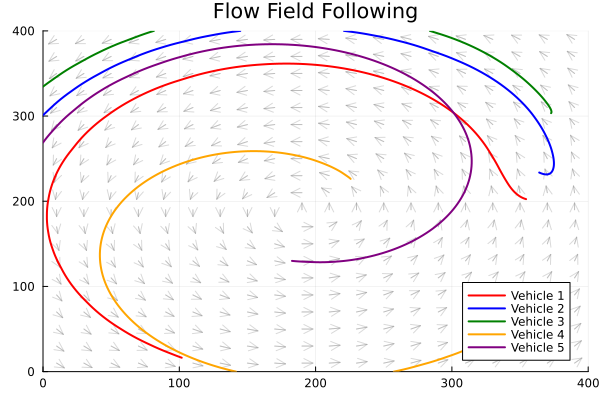

In [7]:
struct FlowField
    resolution::Int
    cols::Int
    rows::Int
    field::Matrix{Vector{Float64}}
end

function FlowField(width::Int, height::Int, resolution::Int)
    cols = width ÷ resolution
    rows = height ÷ resolution
    
    # Perlinノイズ風のフィールドを作成
    field = Matrix{Vector{Float64}}(undef, cols, rows)
    
    for i in 1:cols
        for j in 1:rows
            # 渦巻きパターン
            cx, cy = cols/2, rows/2
            dx, dy = i - cx, j - cy
            angle = atan(dy, dx) + π/2  # 接線方向
            field[i, j] = [cos(angle), sin(angle)]
        end
    end
    
    FlowField(resolution, cols, rows, field)
end

function lookup(ff::FlowField, position::Vector{Float64})
    col = clamp(Int(floor(position[1] / ff.resolution)) + 1, 1, ff.cols)
    row = clamp(Int(floor(position[2] / ff.resolution)) + 1, 1, ff.rows)
    return ff.field[col, row]
end

function follow!(v::Vehicle, ff::FlowField)
    desired = lookup(ff, v.position)
    desired = setmag(desired, v.maxspeed)
    
    steer = desired - v.velocity
    steer = limit(steer, v.maxforce)
    
    applyforce!(v, steer)
end

function simulate_flowfield()
    ff = FlowField(400, 400, 20)
    
    # フローフィールドを表示
    xs = Float64[]
    ys = Float64[]
    us = Float64[]
    vs = Float64[]
    
    for i in 1:ff.cols
        for j in 1:ff.rows
            push!(xs, (i-0.5) * ff.resolution)
            push!(ys, (j-0.5) * ff.resolution)
            push!(us, ff.field[i,j][1] * 8)
            push!(vs, ff.field[i,j][2] * 8)
        end
    end
    
    # 複数のビークルをシミュレート
    vehicles = [Vehicle(rand()*400, rand()*400) for _ in 1:5]
    for v in vehicles
        v.velocity = [rand()*2-1, rand()*2-1]
    end
    
    all_paths = [Vector{Vector{Float64}}() for _ in 1:5]
    
    for _ in 1:200
        for (i, v) in enumerate(vehicles)
            follow!(v, ff)
            update!(v)
            push!(all_paths[i], copy(v.position))
        end
    end
    
    p = quiver(xs, ys, quiver=(us, vs), alpha=0.3, color=:gray)
    
    colors = [:red, :blue, :green, :orange, :purple]
    for (i, path) in enumerate(all_paths)
        plot!([p[1] for p in path], [p[2] for p in path], 
              linewidth=2, color=colors[i], label="Vehicle $i")
    end
    
    title!("Flow Field Following")
    xlims!(0, 400)
    ylims!(0, 400)
end

simulate_flowfield()

## 5.7 Group Behaviors（群れ行動）

Craig Reynoldsの「Boids」アルゴリズムは、3つの単純なルールで複雑な群れ行動を生み出します：

1. **Separation（分離）**: 近くの仲間から離れる
2. **Alignment（整列）**: 近くの仲間と同じ方向に進む
3. **Cohesion（結合）**: 近くの仲間の中心に向かう

In [8]:
mutable struct Boid
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    maxspeed::Float64
    maxforce::Float64
end

function Boid(x::Float64, y::Float64)
    angle = rand() * 2π
    Boid(
        [x, y],
        [cos(angle) * 2, sin(angle) * 2],
        [0.0, 0.0],
        3.0,
        0.05
    )
end

function applyforce!(b::Boid, force::Vector{Float64})
    b.acceleration .+= force
end

function update!(b::Boid, width::Float64, height::Float64)
    b.velocity .+= b.acceleration
    b.velocity = limit(b.velocity, b.maxspeed)
    b.position .+= b.velocity
    b.acceleration .= 0.0
    
    # 境界のラップアラウンド
    if b.position[1] > width; b.position[1] = 0 end
    if b.position[1] < 0; b.position[1] = width end
    if b.position[2] > height; b.position[2] = 0 end
    if b.position[2] < 0; b.position[2] = height end
end

update! (generic function with 2 methods)

In [9]:
# Separation: 近くのBoidから離れる
function separation(b::Boid, boids::Vector{Boid}; desiredSeparation::Float64=25.0)
    steer = [0.0, 0.0]
    count = 0
    
    for other in boids
        d = norm(b.position - other.position)
        if d > 0 && d < desiredSeparation
            diff = normalize(b.position - other.position) / d  # 距離で重み付け
            steer .+= diff
            count += 1
        end
    end
    
    if count > 0
        steer ./= count
        if norm(steer) > 0
            steer = setmag(steer, b.maxspeed) - b.velocity
            steer = limit(steer, b.maxforce)
        end
    end
    
    return steer
end

# Alignment: 近くのBoidと同じ方向に
function alignment(b::Boid, boids::Vector{Boid}; neighborDist::Float64=50.0)
    sum = [0.0, 0.0]
    count = 0
    
    for other in boids
        d = norm(b.position - other.position)
        if d > 0 && d < neighborDist
            sum .+= other.velocity
            count += 1
        end
    end
    
    if count > 0
        sum ./= count
        sum = setmag(sum, b.maxspeed)
        steer = sum - b.velocity
        steer = limit(steer, b.maxforce)
        return steer
    end
    
    return [0.0, 0.0]
end

# Cohesion: 近くのBoidの中心に向かう
function cohesion(b::Boid, boids::Vector{Boid}; neighborDist::Float64=50.0)
    sum = [0.0, 0.0]
    count = 0
    
    for other in boids
        d = norm(b.position - other.position)
        if d > 0 && d < neighborDist
            sum .+= other.position
            count += 1
        end
    end
    
    if count > 0
        target = sum ./ count
        # Seek toward target
        desired = setmag(target - b.position, b.maxspeed)
        steer = desired - b.velocity
        steer = limit(steer, b.maxforce)
        return steer
    end
    
    return [0.0, 0.0]
end

cohesion (generic function with 1 method)

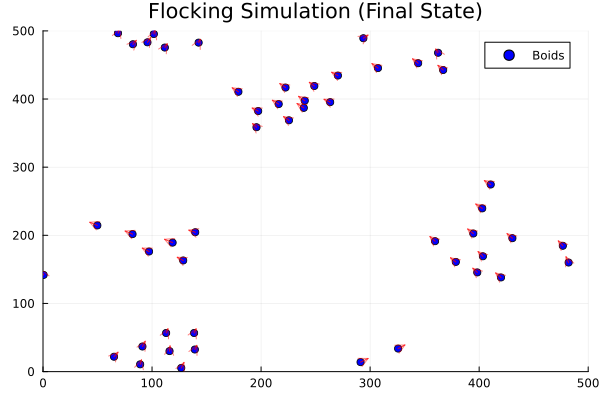

In [10]:
# 3つの行動を組み合わせたFlocking
function flock!(b::Boid, boids::Vector{Boid})
    sep = separation(b, boids)
    ali = alignment(b, boids)
    coh = cohesion(b, boids)
    
    # 重み付け
    sep .*= 1.5
    ali .*= 1.0
    coh .*= 1.0
    
    applyforce!(b, sep)
    applyforce!(b, ali)
    applyforce!(b, coh)
end

function simulate_flocking()
    width, height = 500.0, 500.0
    boids = [Boid(rand()*width, rand()*height) for _ in 1:50]
    
    # 最終フレームの状態を記録
    for _ in 1:300
        for b in boids
            flock!(b, boids)
        end
        for b in boids
            update!(b, width, height)
        end
    end
    
    # 位置と方向を表示
    xs = [b.position[1] for b in boids]
    ys = [b.position[2] for b in boids]
    us = [b.velocity[1] * 3 for b in boids]
    vs = [b.velocity[2] * 3 for b in boids]
    
    scatter(xs, ys, markersize=4, color=:blue, label="Boids")
    quiver!(xs, ys, quiver=(us, vs), color=:red, alpha=0.5)
    title!("Flocking Simulation (Final State)")
    xlims!(0, width)
    ylims!(0, height)
end

simulate_flocking()

## 5.8 創発（Emergence）

Flockingアルゴリズムは**創発**の良い例です：

- 個々のエージェントは単純なルールに従うだけ
- 中央集権的な制御は存在しない
- しかし、群れ全体として複雑で知的に見える行動が現れる

### 創発システムの特徴

1. **非線形性**: 小さな変化が大きな影響を与える
2. **競争と協調**: Separationは競争、Alignment/Cohesionは協調
3. **フィードバックループ**: 出力が入力に影響を与える

## 5.9 パフォーマンス最適化

多数のエージェントを扱う場合、O(n²)の近傍探索がボトルネックになります。

### 最適化テクニック

1. **空間分割（Bin-lattice）**: 空間をグリッドに分割し、隣接セルのみを検索
2. **四分木（Quadtree）**: 密度に応じて動的にグリッドを細分化
3. **距離の二乗を使用**: `mag()`の代わりに`magSq()`で平方根計算を回避
4. **ルックアップテーブル**: sin/cosを事前計算
5. **オブジェクトプーリング**: ベクトルの再利用

In [11]:
# 簡易的な空間分割の例
struct SpatialHash
    cellSize::Float64
    buckets::Dict{Tuple{Int,Int}, Vector{Int}}
end

function SpatialHash(cellSize::Float64)
    SpatialHash(cellSize, Dict{Tuple{Int,Int}, Vector{Int}}())
end

function getKey(sh::SpatialHash, position::Vector{Float64})
    (Int(floor(position[1] / sh.cellSize)), Int(floor(position[2] / sh.cellSize)))
end

function insert!(sh::SpatialHash, position::Vector{Float64}, index::Int)
    key = getKey(sh, position)
    if !haskey(sh.buckets, key)
        sh.buckets[key] = Int[]
    end
    push!(sh.buckets[key], index)
end

function getNearby(sh::SpatialHash, position::Vector{Float64})
    key = getKey(sh, position)
    nearby = Int[]
    
    # 周囲9セルを検索
    for di in -1:1
        for dj in -1:1
            nkey = (key[1] + di, key[2] + dj)
            if haskey(sh.buckets, nkey)
                append!(nearby, sh.buckets[nkey])
            end
        end
    end
    
    return nearby
end

println("空間分割を使用すると、近傍探索がO(n²)からO(n)に改善されます")

空間分割を使用すると、近傍探索がO(n²)からO(n)に改善されます


## まとめ

### 学んだステアリング行動

| 行動 | 説明 |
|------|------|
| Seek | 目標に向かって移動 |
| Flee | 目標から逃げる |
| Arrive | 目標に近づくと減速 |
| Wander | 滑らかなランダム移動 |
| Flow Field Following | フィールドのベクトルに従う |
| Separation | 近くの仲間から離れる |
| Alignment | 近くの仲間と同じ方向に |
| Cohesion | 近くの仲間の中心に向かう |

### 核心公式

```
steering = desired - velocity
```

この単純な式が、複雑で自然に見える動きを生み出す基礎となっています。